In [27]:
# General imports
import numpy as np
import torch

# DeepMoD stuff
from multitaskpinn.model.deepmod import DeepMoD
from multitaskpinn.model.func_approx import NN
from multitaskpinn.model.library import Library1D
from multitaskpinn.model.constraint import LeastSquares
from multitaskpinn.model.sparse_estimators import Clustering, Threshold
from multitaskpinn.training import train, train_optim
from multitaskpinn.training.sparsity_scheduler import Periodic
from phimal_utilities.data import Dataset
from phimal_utilities.data.burgers import BurgersDelta

# Setting cuda
if torch.cuda.is_available():
    torch.set_default_tensor_type('torch.cuda.FloatTensor')

# Settings for reproducibility
np.random.seed(42)
torch.manual_seed(0)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [28]:
# Making data
v = 0.1
A = 1.0
x = np.linspace(-3, 4, 100)
t = np.linspace(0.5, 5.0, 50)

x_grid, t_grid = np.meshgrid(x, t, indexing='ij')
dataset = Dataset(BurgersDelta, v=v, A=A)
X_train, y_train = dataset.create_dataset(x_grid.reshape(-1, 1), t_grid.reshape(-1, 1), n_samples=1000, noise=0.4, random=True)

# Old

In [29]:
# Configuring model
network = NN(2, [30, 30, 30, 30, 30], 1)  # Function approximator
library = Library1D(poly_order=2, diff_order=3) # Library function
estimator = Clustering() # Sparse estimator 
constraint = LeastSquares() # How to constrain
model = DeepMoD(network, library, estimator, constraint) # Putting it all in the model

# Running model
sparsity_scheduler = Periodic(initial_epoch=10000, periodicity=100) # Defining when to apply sparsity
optimizer = torch.optim.Adam(model.parameters(), betas=(0.99, 0.999), amsgrad=True) # Defining optimizer
train(model, X_train, y_train, optimizer, sparsity_scheduler, max_iterations=5000, patience=500, delta=0.01) # Running

| Iteration | Progress | Time remaining |     Loss |      MSE |      Reg |    L1 norm |
         50      1.00%             176s   -3.07e+00   3.43e-02   1.34e-05   2.28e+01 

KeyboardInterrupt: 

In [ ]:
coeffs_old = model(X_train)[-1][0].cpu().detach().numpy()

# New

In [30]:
# Configuring model
network = NN(2, [30, 30, 30, 30, 30], 1)  # Function approximator
library = Library1D(poly_order=2, diff_order=3) # Library function
estimator = Clustering() # Sparse estimator 
constraint = LeastSquares() # How to constrain
model = DeepMoD(network, library, estimator, constraint) # Putting it all in the model

In [31]:
sigma = torch.ones(2) * 0.1
model.sigma = torch.nn.Parameter(sigma)

In [32]:
model.sigma

Parameter containing:
tensor([0.1000, 0.1000], requires_grad=True)

In [33]:
# Running model
sparsity_scheduler = Periodic(initial_epoch=10000, periodicity=100) # Defining when to apply sparsity
optimizer = torch.optim.Adam(model.parameters(), betas=(0.99, 0.999), amsgrad=True) # Defining optimizer
train_optim(model, X_train, y_train, optimizer, sparsity_scheduler, max_iterations=5000, patience=500, delta=0.01) # Running

| Iteration | Progress | Time remaining |     Loss |      MSE |      Reg |    L1 norm |
       5000    100.00%               0s   -9.01e+00   5.46e-03   5.59e-09   1.15e+01 

In [34]:
coeffs_new = model(X_train)[-1][0].cpu().detach().numpy()

In [36]:
sigma

tensor([7.3864e-02, 6.5479e-15])

In [42]:
prediction, time_derivs, sparse_thetas, thetas, constraint_coeffs = model(X_train)
MSE = torch.mean((prediction - y_train)**2, dim=0)  # loss per output
Reg = torch.stack([torch.mean((dt - theta @ coeff_vector)**2) for dt, theta, coeff_vector in zip(time_derivs, sparse_thetas, constraint_coeffs)])

In [59]:
#d = (time_derivs[0] - sparse_thetas[0] @ constraint_coeffs[0]).cpu().detach().numpy()
d = (prediction - y_train).cpu().detach().numpy()

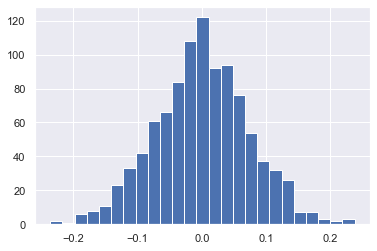

In [60]:
plt.hist(d.squeeze(), bins='auto')
plt.show()

In [61]:
MSE

tensor([0.0055], grad_fn=<MeanBackward1>)

In [62]:
np.std(d)

0.07386241

In [63]:
np.mean(d)

-8.312225e-06

In [64]:
sigma

tensor([7.3864e-02, 6.5479e-15])

# Comparing

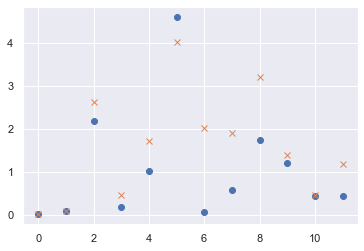

In [26]:
plt.plot(np.abs(coeffs_new), 'o')
plt.plot(np.abs(coeffs_old), 'x')